## Dataset & yolov3 installing 

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
!cp  /content/drive/'My Drive'/bird_dataset.zip /content/ 
!cd /content/ && unzip /content/bird_dataset.zip 

In [0]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/

!apt install gcc-5 g++-5 -y
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc 
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++

%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!make

# get yolov3 weights
# !wget https://pjreddie.com/media/files/yolov3.weights # downloading yolov3 weights
!chmod a+x ./darknet

!cp /drive/'My Drive'/yolov3.weights ../content/darknet/
!pwd
!apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

In [4]:
cd /content/

/content


# Bird extraction with Yolo model

## Sample bird extraction

In [0]:
!cd /content/darknet/ && ./darknet detect cfg/yolov3.cfg yolov3.weights /content/dataset/train_images/026.Bronzed_Cowbird/Bronzed_Cowbird_0037_24032.jpg
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(1*width, 1*height), interpolation = cv2.INTER_CUBIC)

  # fig = plt.gcf()
  # fig.set_size_inches(18, 10)
  # plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
imShow('darknet/predictions.jpg')

## Applying Yolo on all the images

Problem on file : /content/bird_dataset/test_images/mistery_category/0ab685b1515b7d4c76691e8373a65f47.jpg  at index 152
Problem on file : /content/bird_dataset/test_images/mistery_category/4836bedeec2a2617ee33922ebf89995a.jpg  at index 167
Problem on file : /content/bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg  at index 182
Problem on file : /content/bird_dataset/test_images/mistery_category/b5316c8e51b97debf6420b34325ec114.jpg  at index 192
Problem on file : /content/bird_dataset/test_images/mistery_category/4a2fa1c8e573558b1534a1c0802571c7.jpg  at index 272
Problem on file : /content/bird_dataset/test_images/mistery_category/038872d6dfc340d0ff11f8d3c99d026e.jpg  at index 273
Problem on file : /content/bird_dataset/test_images/mistery_category/fb97b3a7197b6f5f856782d39fa14f49.jpg  at index 275
Problem on file : /content/bird_dataset/test_images/mistery_category/6b07f85c04e8485623ee984d132c7a79.jpg  at index 307
Problem on file : /content/bird_dataset/

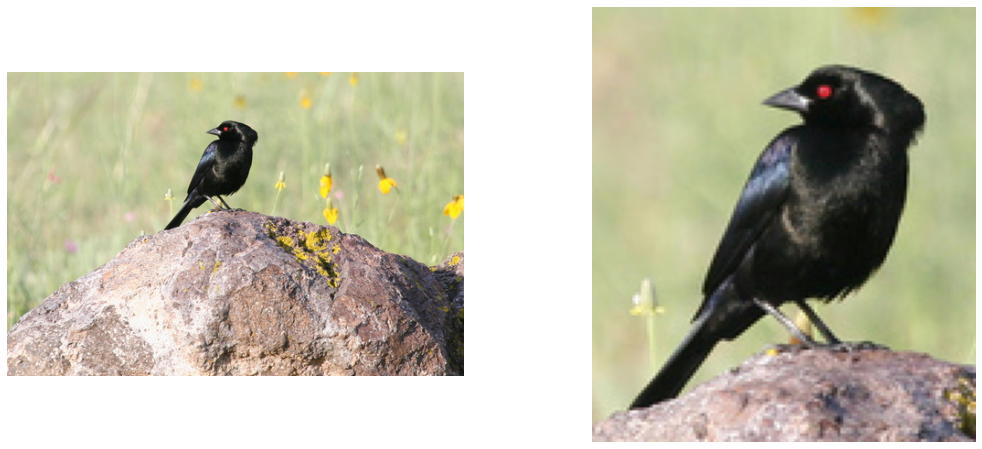

In [9]:
# !cp /content/drive/'My Drive'/yolov3.weights /content/darknet/
# !cd /content/ && mkdir dataset
# !cd /content/ && cp -r bird_dataset/* dataset

# import glob
# bird_list = glob.glob('/content/bird_dataset/*/*/*.jpg')
# with open("/content/train.txt","w") as pred1:
#     for row in bird_list:
#         pred1.write(row + '\n')
# !cd /content/darknet/ && ./darknet detector test cfg/coco.data cfg/yolov3.cfg yolov3.weights -ext_output -dont_show -out /content/result.json < /content/train.txt


!rm -rf bird_dataset
!mkdir bird_dataset
!cp -r dataset/* bird_dataset 

import json
import matplotlib.pyplot as plt
imposs = []
with open('/content/result.json') as json_file:
    data = json.load(json_file)
import tqdm
for i, elt in enumerate(data) :
  
  img = plt.imread(elt['filename'])
  founded = False
  for obj in elt['objects'] :
    if 'bird' in obj['name'] :
      coord = obj['relative_coordinates']
      founded = True
      break 
  if founded :
    x_l = max(0, int((coord['center_x'] - (coord['width'] / 2))*img.shape[1]) -20)
    x_r = int((coord['center_x'] + (coord['width'] / 2))*img.shape[1])  +20
    y_d = max(0, int((coord['center_y'] - (coord['height'] / 2))*img.shape[0]) -20)
    y_u = int((coord['center_y'] + (coord['height'] / 2))*img.shape[0] +20 )

    new_img = img[y_d:y_u, x_l:x_r]
    plt.imsave(elt['filename'], new_img)
  else :
    print("Problem on file :", elt['filename'], ' at index', i) 
    imposs.append(elt['filename'])
    plt.imsave(elt['filename'], img)

#####
## example
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].imshow(img)
ax[1].imshow(new_img)
ax[0].axis('off'); 
ax[1].axis('off');
fig.savefig('extraction.png');
#####

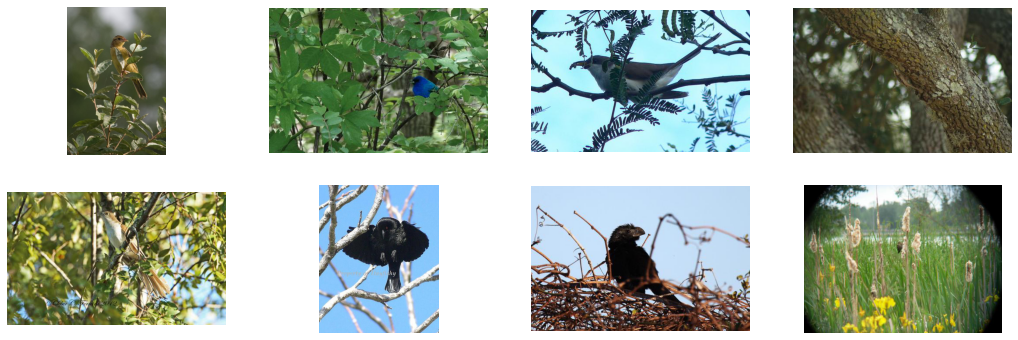

In [25]:
imgs = np.random.choice(imposs, size = 8, replace=False)
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
axes = axes.flatten()
for i in range(8):
  img = plt.imread(imgs[i])
  axes[i].imshow(img)
  axes[i].axis('off')
fig.savefig("extraction_failed.png")

# Bird Classification

## Preprocessing

In [0]:
import zipfile
import os
import torchvision.transforms as transforms
size = 299
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((size, size)),
    # transforms.CenterCrop(size=299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]
                                 )
])
data_transforms_val = transforms.Compose([
    transforms.Resize((size, size)),
    # transforms.CenterCrop(size=299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [0]:
import argparse
import os
import torch
import numpy as np
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
plt.style.use('ggplot')
# Training settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
# Create experiment folder
if not os.path.isdir('experiment'):
    os.makedirs('experiment')
# Data initialization and loading
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/train_images',
                         transform=data_transforms),
    batch_size=64, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/val_images',
                         transform=data_transforms_val),
    batch_size=64, shuffle=False, num_workers=1)

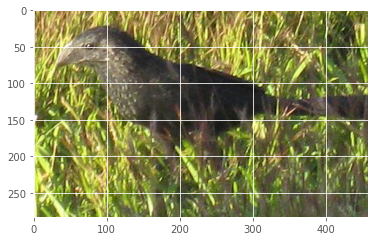

In [3]:
x = plt.imread(train_loader.dataset.samples[10][0])
plt.imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


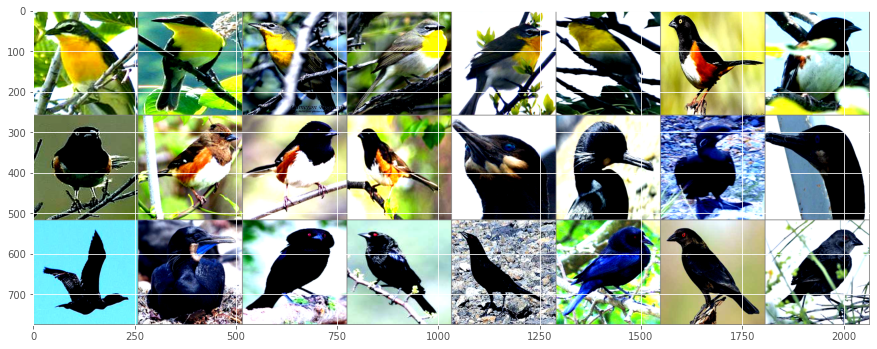

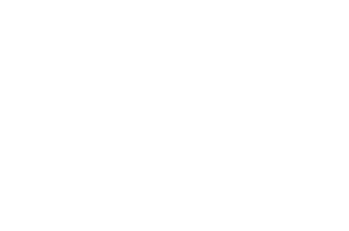

In [4]:
classes = tuple(val_loader.dataset.classes)
from torchvision import datasets, utils
def imshow(img, labels):
    fig = plt.figure(figsize = (15, 8)) 
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.axis('off')
    fig.savefig('sample_birds.png')
# get some random training images
dataiter = iter(val_loader)
images, labels = dataiter.next()
index = np.arange(images.shape[0])
images = images[index]
labels = labels[index]
# show images
imshow(utils.make_grid(images[ 40:]), labels[42:])

## Classification methods

In [0]:
log_interval = 4
def train(epoch, log_interval = log_interval):
    model.train()
    mean_loss = []
    correct = 0
    true_label = []
    predicted_label = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        mean_loss.append(loss.data.item())
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).data.detach().cpu().sum()
        true_label.append(target.data.detach().cpu().numpy())
        predicted_label.append(pred.data.detach().cpu().numpy().reshape(len(pred)))
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                   batch_idx * len(data),
                                                                   len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.data.item()))
    
    return np.mean(mean_loss), 100. * correct / len(train_loader.dataset)
    
import pandas as pd   
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    true_label = []
    predicted_label = []
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        true_label.append(target.cpu().numpy())
        predicted_label.append(pred.cpu().numpy().reshape(len(pred)))
    validation_loss /= len(val_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return 100. * correct / len(val_loader.dataset), validation_loss

In [19]:
!nvidia-smi

Mon May  4 21:24:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |  16263MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Inception Inaturalist

In [0]:
# !wget http://vision.caltech.edu/~macaodha/inat2018/iNat_2018_InceptionV3.pth.tar
import torchvision.models as models
model = models.__dict__['inception_v3'](pretrained=False)
model.fc = nn.Linear(2048, 8142)
model.aux_logits = False
checkpoint = torch.load('/content/iNat_2018_InceptionV3.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
from torchvision import models
model.fc = nn.Sequential(nn.Linear(2048, 20))
# if use_cuda:
#     print('Using GPU')
#     model.cuda()
# else:
#     print('Using CPU')

In [10]:
lr = 0.0008
lr_decay = 0.94
epoch_decay = 4
momentum = 0.9
weight_decay = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            weight_decay=weight_decay)
val_accuracy = []; val_loss = []
mean_loss = []; acc_trains = []
# done = False
dfs = []
for epoch in range(30):
    loss_train, acc_train = train(epoch)
    mean_loss.append(loss_train); acc_trains.append(acc_train)
    acc, val_los = validation()
    val_accuracy.append(acc); val_loss.append(val_los)
torch.save(model.state_dict(), 'model_file');

Train Epoch: 0 [928/1082 (94%)]	Loss: 2.551339
Validation set: Average loss: 0.0433, Accuracy: 71/103 (69%)

Train Epoch: 1 [928/1082 (94%)]	Loss: 1.829913
Validation set: Average loss: 0.0269, Accuracy: 88/103 (85%)

Train Epoch: 2 [928/1082 (94%)]	Loss: 1.323809
Validation set: Average loss: 0.0177, Accuracy: 92/103 (89%)

Train Epoch: 3 [928/1082 (94%)]	Loss: 0.908819
Validation set: Average loss: 0.0133, Accuracy: 92/103 (89%)

Train Epoch: 4 [928/1082 (94%)]	Loss: 0.689885
Validation set: Average loss: 0.0112, Accuracy: 92/103 (89%)

Train Epoch: 5 [928/1082 (94%)]	Loss: 0.563361
Validation set: Average loss: 0.0102, Accuracy: 94/103 (91%)

Train Epoch: 6 [928/1082 (94%)]	Loss: 0.394675
Validation set: Average loss: 0.0093, Accuracy: 94/103 (91%)

Train Epoch: 7 [928/1082 (94%)]	Loss: 0.331821
Validation set: Average loss: 0.0085, Accuracy: 94/103 (91%)

Train Epoch: 8 [928/1082 (94%)]	Loss: 0.314386
Validation set: Average loss: 0.0079, Accuracy: 94/103 (91%)

Train Epoch: 9 [928

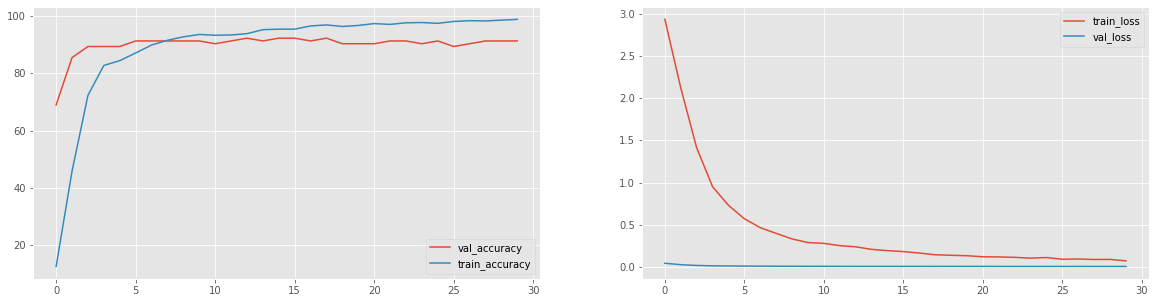

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].plot(acc_trains, label='train_accuracy')
ax[1].plot(mean_loss, label='train_loss')
ax[1].plot(val_loss, label='val_loss')
for i in range(len(ax)) :
  ax[i].legend(loc='best')
fig.savefig('loss_accuracy.png');

### Resnet Model

In [12]:
from torchvision import models 
model = models.resnet101(pretrained=True)
model.fc = nn.Sequential(nn.Linear(2048, 20))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Train Epoch: 0 [928/1082 (94%)]	Loss: 2.119770
Validation set: Average loss: 0.0426, Accuracy: 43/103 (42%)

Train Epoch: 1 [928/1082 (94%)]	Loss: 2.085427
Validation set: Average loss: 0.0417, Accuracy: 54/103 (52%)

Train Epoch: 2 [928/1082 (94%)]	Loss: 2.060105
Validation set: Average loss: 0.0410, Accuracy: 60/103 (58%)

Train Epoch: 3 [928/1082 (94%)]	Loss: 1.887074
Validation set: Average loss: 0.0402, Accuracy: 64/103 (62%)

Train Epoch: 4 [928/1082 (94%)]	Loss: 1.965194
Validation set: Average loss: 0.0400, Accuracy: 66/103 (64%)

Train Epoch: 5 [928/1082 (94%)]	Loss: 2.030647
Validation set: Average loss: 0.0393, Accuracy: 67/103 (65%)

Train Epoch: 6 [928/1082 (94%)]	Loss: 1.901276
Validation set: Average loss: 0.0391, Accuracy: 66/103 (64%)

Train Epoch: 7 [928/1082 (94%)]	Loss: 1.887419
Validation set: Average loss: 0.0388, Accuracy: 67/103 (65%)

Train Epoch: 8 [928/1082 (94%)]	Loss: 1.802748
Validation set: Average loss: 0.0384, Accuracy: 67/103 (65%)

Train Epoch: 9 [928

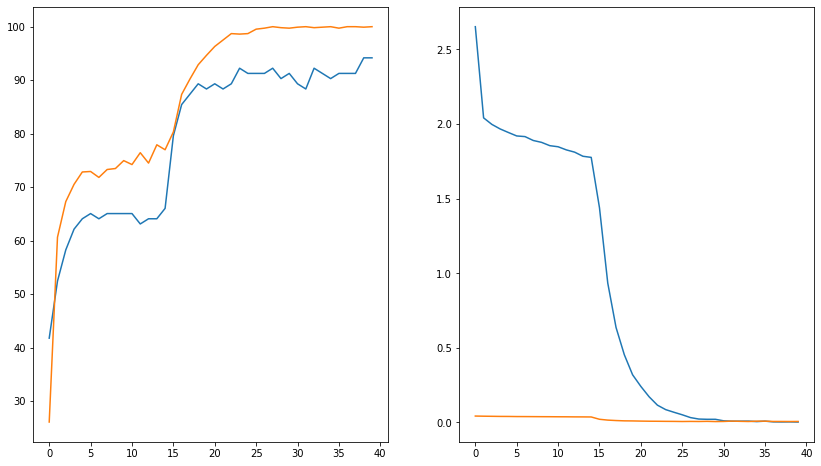

In [13]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(2048, 20))
model.cuda();
optimizer  = torch.optim.Adam(model.parameters(), lr= 0.001)
val_accuracy = []; val_loss = []
mean_loss = []; acc_trains = []
# model.layer3.requires_grad_(True)
done = False
dfs = []
for epoch in range(0, 40):
    if epoch >= 15 and not done :
        model.layer4.requires_grad_(True)
        model.layer3.requires_grad_(True)
        #model.layer2.requires_grad_(True)
        print('stop freezing')
        done = True
    loss_train, acc_train = train(epoch)
    mean_loss.append(loss_train); acc_trains.append(acc_train)
    acc, val_los = validation()
    val_accuracy.append(acc); val_loss.append(val_los)
    optimizer = optim.Adam(model.parameters(), lr=0.001/50)
torch.save(model.state_dict(), 'resnet_model')        
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].plot(val_accuracy)
ax[0].plot(acc_trains)
ax[1].plot(mean_loss)
ax[1].plot(val_loss)

## TSNE of an inner representation of birds

In [0]:
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/val_images',
                         transform=data_transforms_val),
    batch_size=128, shuffle=False, num_workers=1)

for data, target in val_loader:
    if use_cuda:
        data_test, target = data, target
        pass
    break

In [0]:
## For inceptionv3
import torch.nn.functional as F
def extractor(self, x):
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.adaptive_avg_pool2d(x, 1)
        #x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = F.dropout(x)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        return x
inner_representation = extractor(model, data_test).detach().data.cpu().numpy()

In [0]:
## For resnet
new_model = nn.Sequential(*list(model.children())[:-1]).cpu()
new_model.eval()
inner_representation = new_model(data_test).data.cpu().numpy()

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
cmap = plt.get_cmap("tab20") 
import matplotlib
import colorsys
colorNames = list(matplotlib.colors.cnames.keys())
colorNames.sort(key = lambda x: colorsys.rgb_to_hsv(
  *matplotlib.colors.colorConverter.to_rgb(matplotlib.colors.cnames[x])))
cols = np.random.choice(colorNames, size=20, replace=False)
def visualize_doc_embeddings(my_doc_embs, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2, perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx, elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                  #  cmap = cmap(i),
                   color = cols[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))   
    # ax.legend(scatterpoints=1)
    fig.suptitle(my_name,
                 fontsize=20)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
    return fig, ax

In [0]:
dico = {elt : value for value, elt in val_loader.dataset.class_to_idx.items()}
my_labels = [dico[elt].split('.')[-1] for elt in target.data.cpu().numpy()]

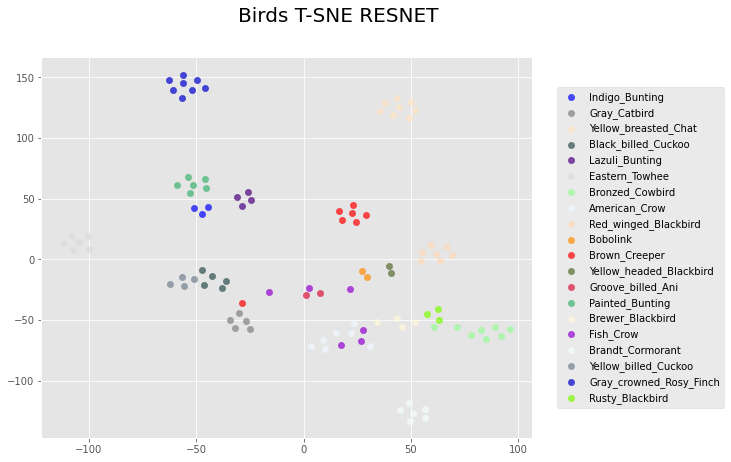

In [46]:
fig, ax = visualize_doc_embeddings(inner_representation[:, :, 0, 0], my_labels, 'Birds T-SNE RESNET')

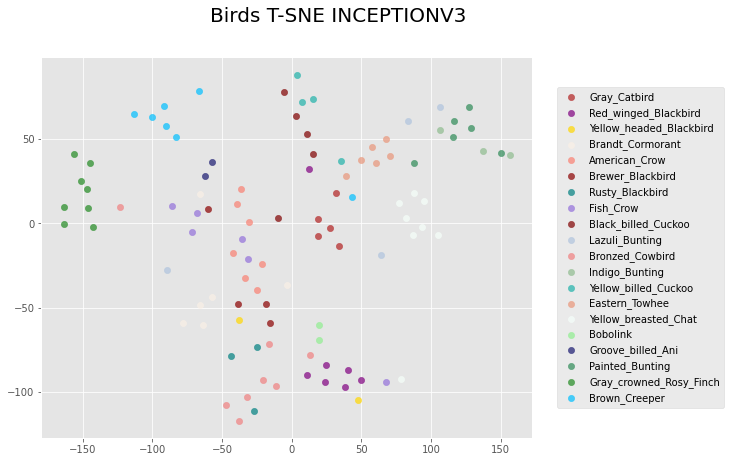

In [126]:
fig, ax = visualize_doc_embeddings(inner_representation, my_labels, 'Birds T-SNE INCEPTIONV3')

## Testing the model

In [14]:
model.eval()
import PIL.Image as Image
import os

test_dir = '/content/bird_dataset' + '/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open('/content/test.txt', "w")
output_file.write("Id,Category\n")
for f in os.listdir(test_dir):
    if 'jpg' in f:
        data = data_transforms_val(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote you can upload this file to the kaggle competition website")

Succesfully wrote you can upload this file to the kaggle competition website
